In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
tf.version.VERSION

'2.16.1'

In [3]:
data_dir = "C:\\Users\\hetar\\OneDrive\\Desktop\\hj code\\PotatoDisease\\data"
BatchSize=32
epoch = 10
img_size = 256
channels=3

In [4]:
currdir = os.getcwd()
data_dir = os.path.dirname(currdir) + "\\data"
print(currdir,data_dir)

c:\Users\hetar\OneDrive\Desktop\hj code\PotatoDisease\training c:\Users\hetar\OneDrive\Desktop\hj code\PotatoDisease\data


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(256,256),
    shuffle=True,
    batch_size=BatchSize)
classname = dataset.class_names

Found 2152 files belonging to 3 classes.


In [6]:
print(dataset.class_names)
print(len(dataset))

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68


In [7]:
dataset
# the dataset is a tuple with images and class_labels

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

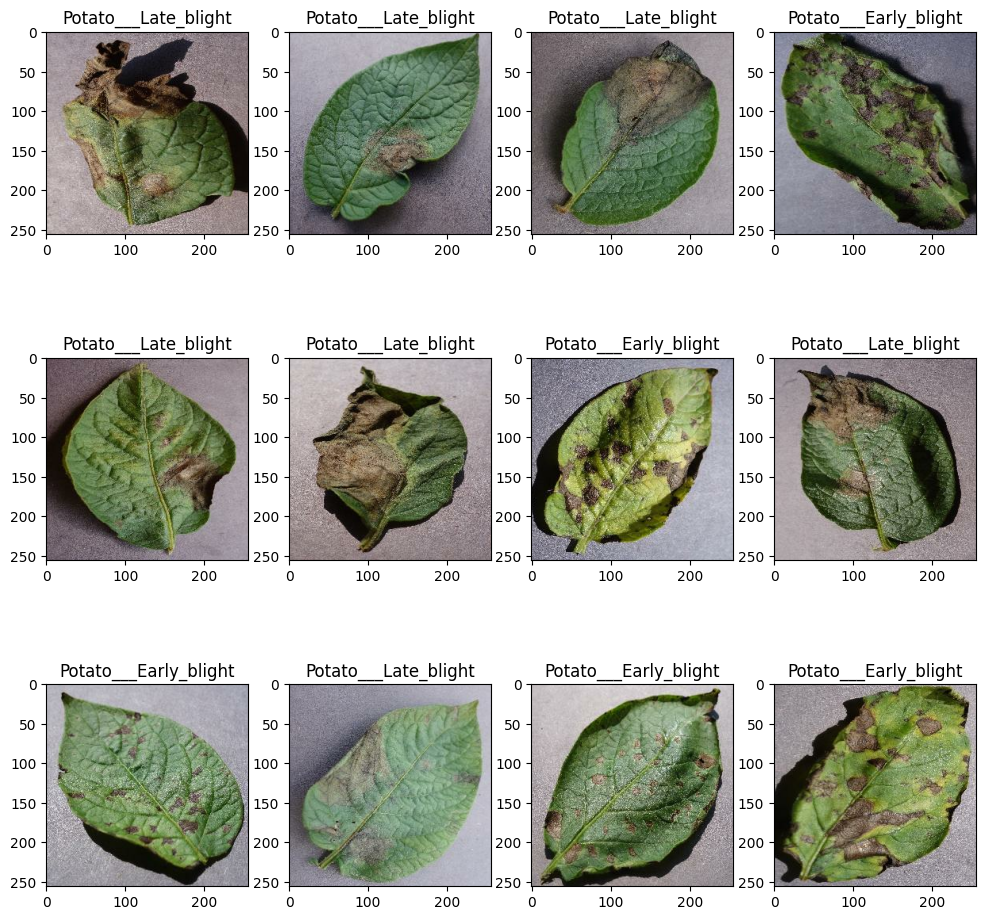

In [8]:
# 
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classname[label_batch[i]])

In [9]:
def get_dataset_partitions(dataset,train_split=0.8, val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
    size = len(dataset)
    train_size = int(train_split*size)
    val_size = int(val_split*size)
    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size+val_size)
    return train_data,val_data,test_data

In [10]:
train_data, val_data, test_data = get_dataset_partitions(dataset)
print(len(train_data),len(val_data),len(test_data))

54 6 8


In [11]:
# Optimizing the dataset for training
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
# data rescaling
resize = tf.keras.Sequential([
	tf.keras.layers.Resizing(256,256),
	tf.keras.layers.Rescaling(1.0/255)
])
# data augmentation
augmentation = tf.keras.Sequential([
	tf.keras.layers.RandomFlip("horizontal_and_vertical"),
	tf.keras.layers.RandomRotation(0.2)
])

In [13]:
outputClasses = 3
# Model
model = models.Sequential([
    resize,
    augmentation,
    layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=(BatchSize,img_size,img_size,channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(outputClasses,activation="softmax")
    ])
model.build(input_shape=(BatchSize,img_size,img_size,channels))
model.summary()


c:\Users\hetar\.conda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 256, 256, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 128, 128, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 128, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 16384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 3)                │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,723 (448.14 KB)

 Trainable params: 114,723 (448.14 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [1]:
model = tf.keras.models.load_model("models/1.keras")

NameError: name 'tf' is not defined

In [16]:
history = model.fit(train_data,validation_data=val_data,epochs=50)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5854 - loss: 0.8542 - val_accuracy: 0.8229 - val_loss: 0.5498
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8414 - loss: 0.4245 - val_accuracy: 0.6250 - val_loss: 0.9519
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8814 - loss: 0.3160 - val_accuracy: 0.9115 - val_loss: 0.2490
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 833ms/step - accuracy: 0.8956 - loss: 0.2537 - val_accuracy: 0.9323 - val_loss: 0.1974
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.9317 - loss: 0.1458 - val_accuracy: 0.8542 - val_loss: 0.3356


In [17]:
print(history.params)
print(history.history.keys())

{'verbose': 'auto', 'epochs': 5, 'steps': 54}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


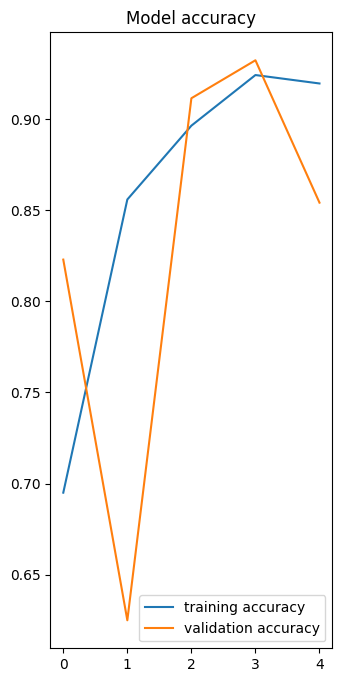

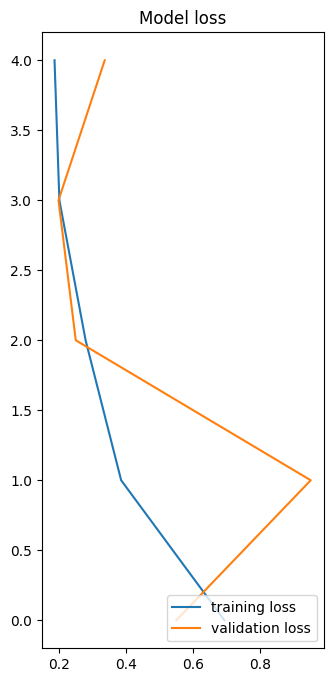

In [18]:
# Plotting the training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),history.history["accuracy"],label="training accuracy")
plt.plot(range(5),history.history["val_accuracy"],label="validation accuracy")
plt.title("Model accuracy")
plt.legend(loc='lower right')

# Plotting the training and validation loss
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],range(5),label="training loss")
plt.plot(history.history["val_loss"],range(5),label="validation loss")
plt.title("Model loss")
plt.legend(loc='lower right')

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = classname[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [26]:
# def prediction(model, img):
#     imgarr = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
#     imgarr = np.expand_dims(imgarr, 0)
#     pred = model.predict(imgarr)
#     predClass = classname[np.argmax(pred[0])]
#     Confidence = round(100 * (np.max(pred[0])), 2)
#     return predClass, Confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


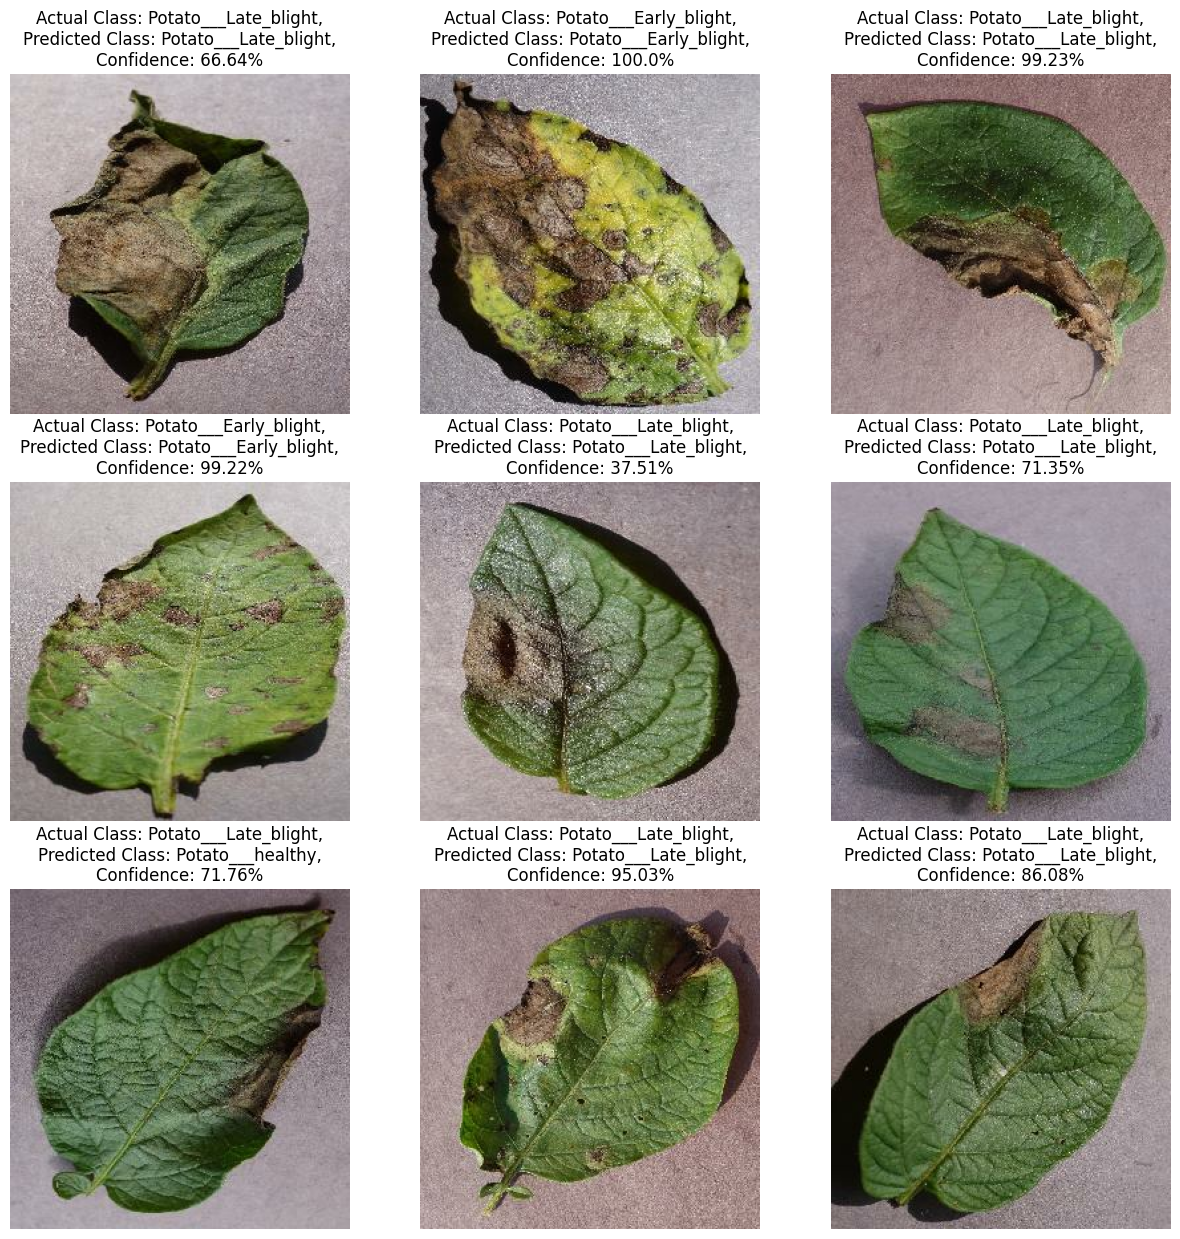

In [28]:
plt.figure(figsize=(15, 15))
for image, labels in test_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        predClass, Confidence = predict(model, image[i])
        actualClass = classname[labels[i].numpy()]
        plt.title(f"Actual Class: {actualClass},\nPredicted Class: {predClass},\nConfidence: {Confidence}%")
        plt.axis("off")

In [39]:
model_path = "C:\\Users\\hetar\\OneDrive\\Desktop\\hj code\\PotatoDisease\\models"
# Determine the latest model version and save the new model
existing_models = [int(i.split('.')[0]) for i in os.listdir(model_path) if i.split('.')[0].isdigit()]
model_version = max(existing_models, default=0) + 1  # Start from 1 if no models exist
saved_path = f"{model_path}/{model_version}.keras"
model.save(saved_path)

print(f"""Model saved to {saved_path}""")

Model saved to C:\Users\hetar\OneDrive\Desktop\hj code\PotatoDisease\models/2.keras
